In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.datasets import make_classification
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import kagglehub
import zipfile
import os

# Download latest version
path = kagglehub.dataset_download("imuhammad/course-reviews-on-coursera")

print("Path to dataset files:", path)

files = os.listdir(path)
print("Files in dataset directory:", files)

100%|██████████| 33.1M/33.1M [00:01<00:00, 32.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/imuhammad/course-reviews-on-coursera/versions/1
Files in dataset directory: ['Coursera_courses.csv', 'Coursera_reviews.csv']


In [2]:
courses_csv = os.path.join(path, "Coursera_courses.csv")
reviews_csv = os.path.join(path, "Coursera_reviews.csv")

# Load CSVs into DataFrames
coursera_courses = pd.read_csv(courses_csv)
course_review = pd.read_csv(reviews_csv)

print(coursera_courses.head())
print(course_review.head())


                                                name  \
0                                   Machine Learning   
1                                  Indigenous Canada   
2                          The Science of Well-Being   
3                     Technical Support Fundamentals   
4  Become a CBRS Certified Professional Installer...   

                 institution  \
0        Stanford University   
1      University of Alberta   
2            Yale University   
3                     Google   
4  Google - Spectrum Sharing   

                                          course_url  \
0    https://www.coursera.org/learn/machine-learning   
1   https://www.coursera.org/learn/indigenous-canada   
2  https://www.coursera.org/learn/the-science-of-...   
3  https://www.coursera.org/learn/technical-suppo...   
4  https://www.coursera.org/learn/google-cbrs-cpi...   

                        course_id  
0                machine-learning  
1               indigenous-canada  
2       the-science-of-we

In [3]:
coursera_courses.shape, course_review.shape

((623, 4), (1454711, 5))

In [4]:
coursera_courses.head()

,name,institution,course_url,course_id
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning
1,Indigenous Canada,University of Alberta,https://www.coursera.org/learn/indigenous-canada,indigenous-canada
2,The Science of Well-Being,Yale University,https://www.coursera.org/learn/the-science-of-...,the-science-of-well-being
3,Technical Support Fundamentals,Google,https://www.coursera.org/learn/technical-suppo...,technical-support-fundamentals
4,Become a CBRS Certified Professional Installer...,Google - Spectrum Sharing,https://www.coursera.org/learn/google-cbrs-cpi...,google-cbrs-cpi-training


In [5]:
course_review.head()

,reviews,reviewers,date_reviews,rating,course_id
0,"Pretty dry, but I was able to pass with just t...",By Robert S,"Feb 12, 2020",4,google-cbrs-cpi-training
1,would be a better experience if the video and ...,By Gabriel E R,"Sep 28, 2020",4,google-cbrs-cpi-training
2,Information was perfect! The program itself wa...,By Jacob D,"Apr 08, 2020",4,google-cbrs-cpi-training
3,A few grammatical mistakes on test made me do ...,By Dale B,"Feb 24, 2020",4,google-cbrs-cpi-training
4,Excellent course and the training provided was...,By Sean G,"Jun 18, 2020",4,google-cbrs-cpi-training


In [6]:
combined_data = pd.merge(coursera_courses, course_review, on='course_id', how='inner')

combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,"Mar 18, 2017",1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,"Nov 09, 2015",1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,"Apr 15, 2019",1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,"Sep 25, 2015",1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,"Dec 12, 2015",1


In [7]:
# Let's get the range of the dates
combined_data['date_reviews'] = pd.to_datetime(combined_data['date_reviews'], errors='coerce')

date_min = combined_data['date_reviews'].min()
date_max = combined_data['date_reviews'].max()

print("Date Range of Reviews:")
print("Earliest Review Date:", date_min)
print("Latest Review Date:", date_max)


Date Range of Reviews:
Earliest Review Date: 2015-08-07 00:00:00
Latest Review Date: 2020-10-10 00:00:00


In [8]:
combined_data['rating'].value_counts()

,count
rating,
5,1146164
4,226702
3,48303
1,17354
2,16188


In [9]:
df = combined_data[['rating','reviews']]

In [10]:
df.isna().sum()

,0
rating,0
reviews,153


In [11]:
df.duplicated().sum()

993566

In [12]:
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)

<ipython-input-12-2960a2f9b025>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop_duplicates(inplace=True)
<ipython-input-12-2960a2f9b025>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [13]:
df.duplicated().sum(),df.isna().sum()

(0,
 rating     0
 reviews    0
 dtype: int64)

In [14]:
df['rating'].value_counts()

,count
rating,
5,356174
4,75310
3,17212
1,6445
2,5999


<Axes: xlabel='rating'>

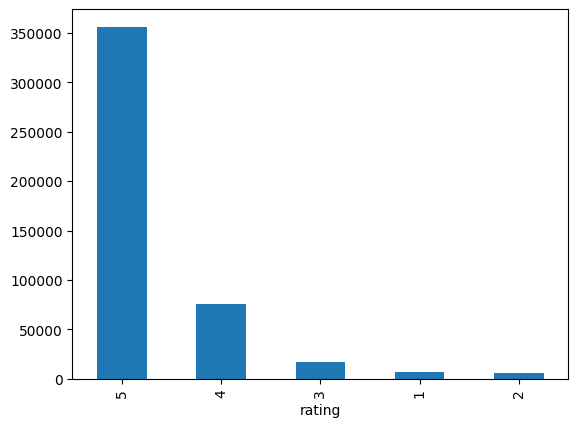

In [15]:
df['rating'].value_counts().plot(kind='bar')

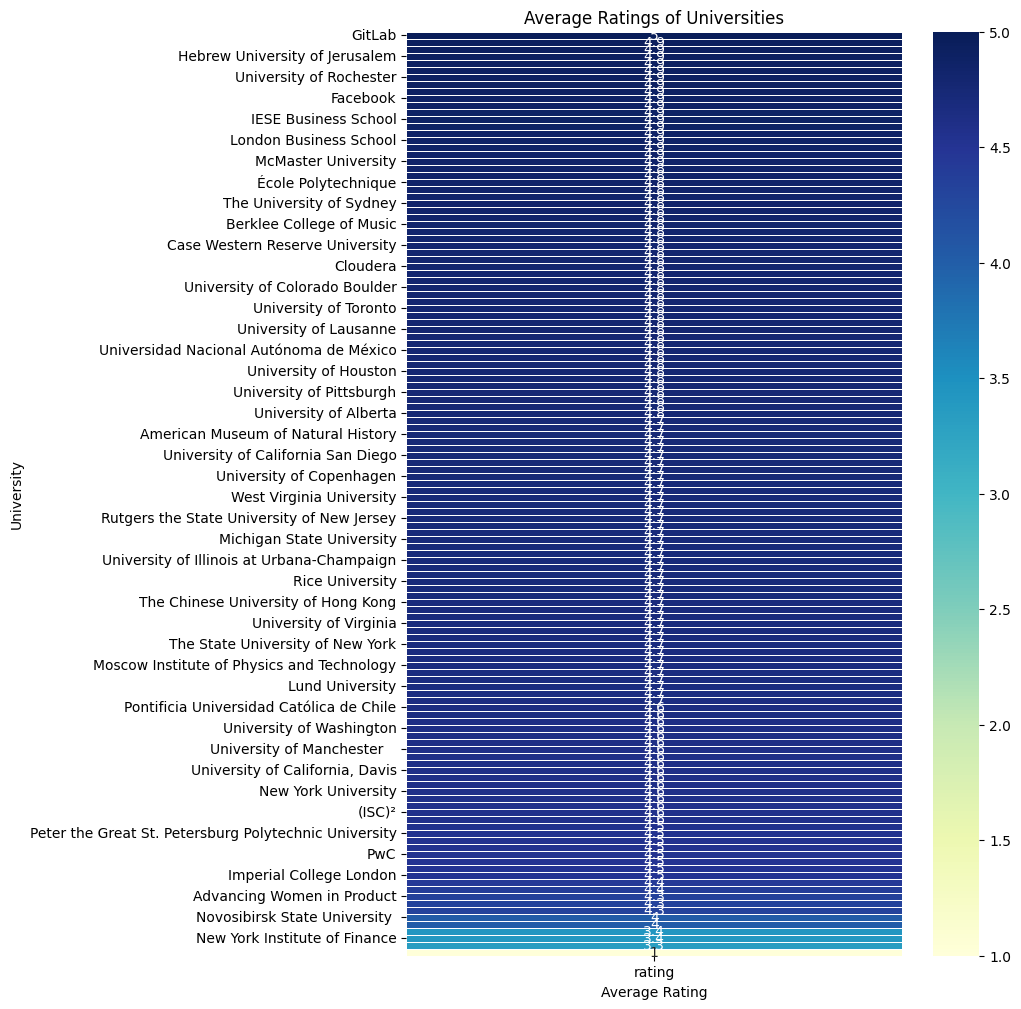

In [16]:
# Let's see what the distribution of universities looks like

university_ratings = combined_data.groupby('institution')['rating'].mean().sort_values(ascending=False)

heatmap_data = pd.DataFrame(university_ratings)

plt.figure(figsize=(8, 12))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", cbar=True, linewidths=0.5)

plt.title("Average Ratings of Universities")
plt.xlabel("Average Rating")
plt.ylabel("University")
plt.show()

In [17]:
combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1


In [18]:
combined_data = combined_data.dropna(subset=['reviews', 'rating'])  # Drop rows where reviews or rating is missing

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Text Cleaning for 'reviews' Column
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Tokenize and remove stop words
    tokens = [word for word in text.split() if word not in stop_words]
    # Lemmatize each word
    lemmatized = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized)

combined_data['cleaned_reviews'] = combined_data['reviews'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [19]:
combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,cleaned_reviews
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1,extremely basic course machine learning built ...
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1,course ok certification procedure messno state...
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1,started week admit good course explaining idea...
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1,course absolute garbage get feedback quiz assi...
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1,however good material lecture may use outdated...


In [20]:
# combined_data.to_csv("Data/combined_data_preprocessed.csv", index=False)

In [21]:
# Feature Engineering: Calculate Average Rating, Review Count per Course
course_stats = combined_data.groupby('course_id').agg(
    avg_rating=('rating', 'mean'),
    review_count=('rating', 'count')
).reset_index()

# Merge back into original dataframe
combined_data = combined_data.merge(course_stats, on='course_id', how='left')

# 5. Normalize Rating and Review Count
scaler = StandardScaler()
combined_data[['normalized_rating', 'normalized_review_count']] = scaler.fit_transform(
    combined_data[['avg_rating', 'review_count']]
)

In [22]:
combined_data.head()

,name,institution,course_url,course_id,reviews,reviewers,date_reviews,rating,cleaned_reviews,avg_rating,review_count,normalized_rating,normalized_review_count
0,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This is an extremely basic course. Machine lea...,By Deleted A,2017-03-18,1,extremely basic course machine learning built ...,4.750522,35895,0.277837,2.014222
1,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,The course is ok but the certification procedu...,By Bruno C,2015-11-09,1,course ok certification procedure messno state...,4.750522,35895,0.277837,2.014222
2,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"I just started week 3 , I have to admit that I...",By Fadi,2019-04-15,1,started week admit good course explaining idea...,4.750522,35895,0.277837,2.014222
3,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,This course is absolute garbage. You get no f...,By Mathew L,2015-09-25,1,course absolute garbage get feedback quiz assi...,4.750522,35895,0.277837,2.014222
4,Machine Learning,Stanford University,https://www.coursera.org/learn/machine-learning,machine-learning,"However good the material and lectures may be,...",By Rui C,2015-12-12,1,however good material lecture may use outdated...,4.750522,35895,0.277837,2.014222


In [25]:

import pandas as pd
from transformers import pipeline
import torch

# Check if CUDA (GPU) is available
device = 0 if torch.cuda.is_available() else -1
print(f"CUDA Available: {torch.cuda.is_available()}")

# Assuming 'combined_data' is your DataFrame containing the 'reviews' column
#sampled_df = combined_data.head(100)  # Replace with actual DataFrame, e.g., combined_data.sample(frac=0.05)
sampled_df = combined_data.sample(frac=0.05, random_state=42)
batch_size = 64  # Adjust based on available GPU memory

# Load the pre-trained model
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment"
classifier = pipeline("text-classification", model=MODEL_NAME, device=device, truncation=True, padding=True, max_length=512)  # Use GPU if available

# Define a mapping from model labels to sentiment categories
label_mapping = {
    'LABEL_0': 'negative',
    'LABEL_1': 'neutral',
    'LABEL_2': 'positive'
}

# Function to classify reviews in batches
def classify_batch(batch):
    reviews = batch['reviews'].tolist()  # Convert reviews column to a list
    results = classifier(reviews)  # Perform classification
    sentiments = []
    for result in results:
        sentiment = label_mapping[result['label']]  # Map the label to sentiment
        score = result['score']  # Get the sentiment score
        sentiments.append((sentiment, score))  # Append a tuple of sentiment and score
    return sentiments

# Split the DataFrame into batches and process
def process_in_batches(df, batch_size):
    sentiment_labels = []  # Store the sentiment results

    # Iterate through DataFrame in batches
    for start in range(0, len(df), batch_size):
        batch = df.iloc[start:start + batch_size]  # Get the current batch
        sentiments = classify_batch(batch)  # Get sentiment for the batch
        sentiment_labels.extend(sentiments)  # Append results to the list

    return sentiment_labels

# Process reviews and classify sentiment with scores
sentiments_with_scores = process_in_batches(sampled_df, batch_size)  # Classify the reviews

# Separate the results into two columns: 'sentiment' and 'score'
sampled_df['sentiment'] = [sentiment for sentiment, score in sentiments_with_scores]
sampled_df['sentiment_score'] = [score for sentiment, score in sentiments_with_scores]

# Preview the updated DataFrame with sentiment and scores
sampled_df[['reviews', 'sentiment', 'sentiment_score']]




CUDA Available: True


,reviews,sentiment,sentiment_score
182182,"Very well structured material, hands on exampl...",positive,0.912355
1244215,I have grown so much in so little time. Whethe...,positive,0.981476
419060,Great intro and overview of industry. Tests ha...,positive,0.479570
1331513,i really enjoyed this course,positive,0.985112
434243,Thanks for the course.,positive,0.897783
...,...,...,...
1239475,Fantastic course,positive,0.817385
1052018,"Course well planned and easily understandable,...",positive,0.806054
1128281,I really gain knowledge how to project should...,positive,0.572156
437801,"Very good, but I would expect a bit more.",positive,0.864989


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
